Обозначения:

p - глубина истории, сколько измерений назад учитываем в моделях

h - горизонт прогноза , на сколько измерений вперед смотрим при моделировании (как далеко предсказываем)

Прочитайте базу "Потребление Энергии" (или BRENT(сделать анализ пропусков и больше чем 2-х дневные заполнить, и работаем для 3-х дневного ресемплинга), или COVID-19(выбрать любую страну кроме Бразилии)) и сделайте модель основных изменений по data_exp_1(сглаженной) с глубиной прогноза h=1 и h=10 по образцу из примера для обработки ряда "цена Нефти" .

In [1]:
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
df_pjme = pd.read_csv('my_PJME_MW.csv', index_col=[0], parse_dates=[0])

In [3]:
df_pjme.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


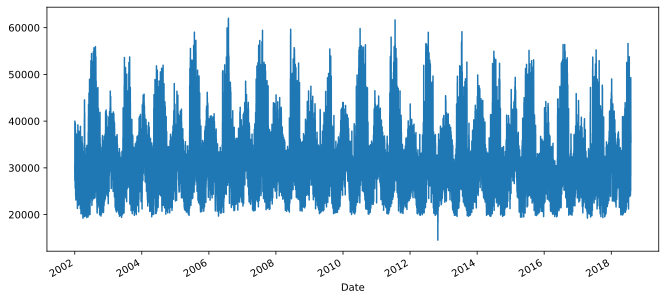

In [4]:
df_pjme.PJME_MW.plot(figsize=(11,5));

In [5]:
df_pjme.describe()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
count,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000
mean,32079.773047,2009.801340,6.435979,15.722681,2.481241,180.459835,26.218643,2.999168,11.501101,0.027233,0.027075,0.027240
std,6464.167501,4.791885,3.438982,8.801258,1.114448,105.138073,15.019836,1.999572,6.921927,0.162763,0.162303,0.162783
min,14544.000000,2002.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27573.000000,2006.000000,3.000000,8.000000,1.000000,90.000000,13.000000,1.000000,6.000000,0.000000,0.000000,0.000000
50%,31421.000000,2010.000000,6.000000,16.000000,2.000000,179.000000,26.000000,3.000000,12.000000,0.000000,0.000000,0.000000
75%,35648.750000,2014.000000,9.000000,23.000000,3.000000,271.000000,39.000000,5.000000,18.000000,0.000000,0.000000,0.000000
max,62009.000000,2018.000000,12.000000,31.000000,4.000000,366.000000,53.000000,6.000000,23.000000,1.000000,1.000000,1.000000


In [6]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [7]:
data_exp_1 = exponential_smoothing(df_pjme.PJME_MW  , 0.05)

In [8]:
df = pd.DataFrame(data_exp_1, columns=['exponential_smoothing_0.05'], index=df_pjme.index)

In [9]:
for i in range(1,4):
    df[f't{i}']=0.0
    df.iloc[i:,i]=df.iloc[:-i,0].values
df.head()

,exponential_smoothing_0.05,t1,t2,t3
Date,,,,
2002-01-01,30393.00000,0.000,0.00,0.0
2002-01-01,30336.60000,30393.000,0.00,0.0
2002-01-01,30237.62000,30336.600,30393.00,0.0
2002-01-01,30120.68900,30237.620,30336.60,30393.0
2002-01-01,30017.50455,30120.689,30237.62,30336.6


In [10]:
def split_data_b(data, split_date):
    return data.loc[data.index <= split_date].copy(), \
           data.loc[data.index >  split_date].copy()

In [11]:
train_b, test_b = split_data_b(df, '01-01-2018')

In [12]:
model = GradientBoostingRegressor(max_depth=10, random_state=42, n_estimators=100)

In [13]:
def predict_model(model, h, train_b, test_b):

    X_train_b = train_b.iloc[:-h,:]
    y_train_b = train_b[df.columns[0]].values[h:]
    X_test_b = test_b.iloc[:-h,:]
    y_test_b = test_b[df.columns[0]].values[h:]

    model.fit(X_train_b, y_train_b)
    X_test_pred = model.predict(X_test_b)
    return X_test_pred, y_test_b

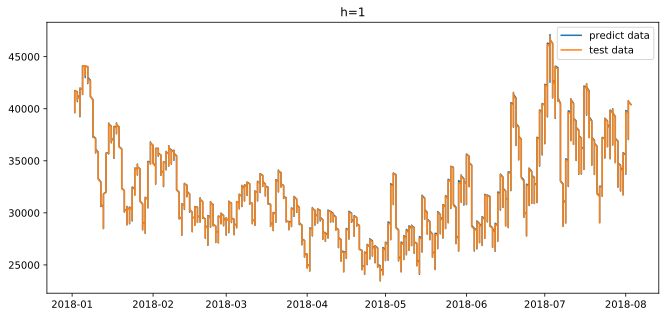

In [14]:
h=1
X_test_pred_h1, y_test_b_h1 = predict_model(model, h, train_b, test_b)

plt.figure(figsize=(11, 5))

plt.plot(test_b.index[h:],X_test_pred_h1, label='predict data')
plt.plot(test_b.index[h:],y_test_b_h1, label='test data')

plt.title(f'h={h}')
plt.legend()
plt.show()

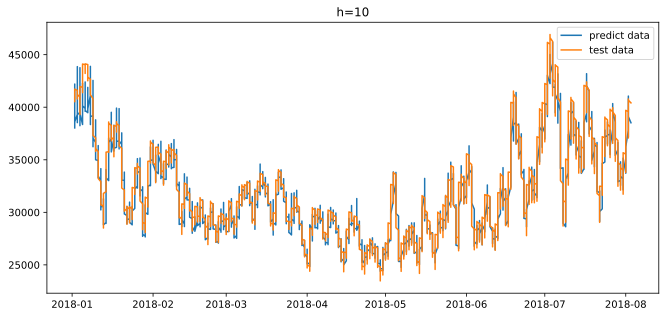

In [15]:
h=10
X_test_pred_h10, y_test_b_h10 = predict_model(model, h, train_b, test_b)

plt.figure(figsize=(11, 5))

plt.plot(test_b.index[h:],X_test_pred_h10, label='predict data')
plt.plot(test_b.index[h:],y_test_b_h10, label='test data')

plt.title(f'h={h}')
plt.legend()
plt.show()

Оцените ошибку модели из п.1 .

In [16]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [17]:
print(f'Error h=1: {mean_absolute_percentage_error(y_test_b_h1, X_test_pred_h1):.02f}%')
print(f'Error h=10: {mean_absolute_percentage_error(y_test_b_h10, X_test_pred_h10):.02f}%')

Error h=1: 0.11%
Error h=10: 3.34%


Сделайте вывод о том, как изменилась ошибка модели по значениям h.

С увеличением горизонта прогноза, увеличивается ошибка, нужно регулировать глубину истории совместно с горизонтом прогноза


Попробуйте предположить характер ряда (стационарный или нет, с трендом, с сезоном, с циклом) для рядов из списка и аргументируйте свой ответ (одна строка):

а) Изменение температуры за окном :).

б) Количество денег, которые тратят покупатели в интернет магазине.

в) Вес растущего котенка.

г) Прирост объема деревьев в лесу от времени

а) Сезонный, с циклом , в зависимости от времени года и времени суток, с трендом, глобальное потепление, и наоборот приближение к похолоданию, все зависит от того какой промежуток брать, возможно на довольно большом промежутке и глобальные циклы уйдут в шум
 
б)  циклы, взаимосвязь с праздниками, сезонами в продукции, тренд может наблюдаться при развитии сети магазина, 
    стационарность может наблюдаться у магазина, с постоянной клиентурой, при отсутствии необходимости постоянного роста ассортимента

в) тренд, пока особь формируется, постоянное возрастание, циклы в теченни дня и в зависимости от сезона (активный сезон или накапливающий жирок) можно наблюдать стационарность, если взять отрезок за пару лет в середине жизни

г) если убрать влияние человека, то можно наблюдать тренд на возрастание, до определенного пика, сезонность из-за естественных пожаров, если с человеком, то тут идет прямая взаимосвязь со сторонними процессами, поэтому можно наблюдать любое развитие событий